In [2]:
"""Preprocessing Neural Spike Data."""

'Preprocessing Neural Spike Data.'

In [3]:
import importlib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np

import nrtk.io
import nrtk.vis
importlib.reload(nrtk.io)
importlib.reload(nrtk.vis)

import warnings
warnings.filterwarnings("ignore")

OUTPUT_DIR = '/scratch/users/nmiolane/sommet/output'
HOME_DIR = '/home/nina/code/sommet'
DATA_DIR = os.path.join('/neuro/recordings', '2018-05-31_15-43-39')
# TODO(nina): Look at this https://github.com/vandermeerlab/nept/blob/master/nept/loaders_neuralynx.py

np.random.seed(seed=1990)

# Load Signals

In [2]:
signals_path = os.path.join(OUTPUT_DIR, 'load_signals.npy')
signals = np.load(signals_path)

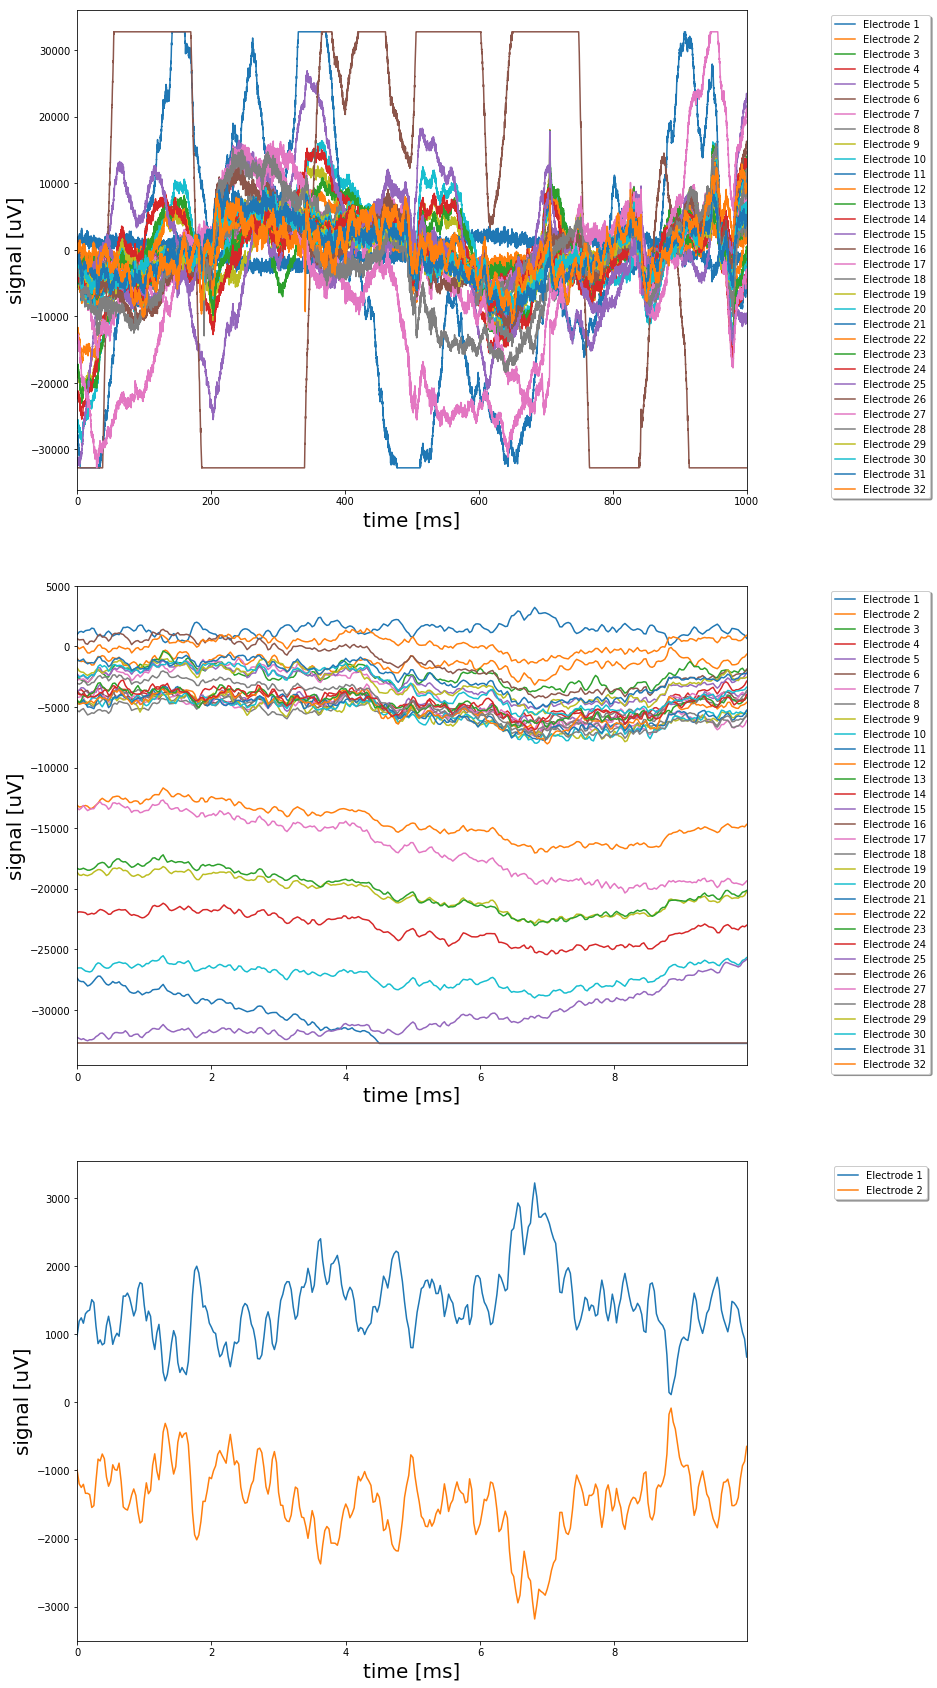

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

ax = axes[0]
ax = nrtk.vis.plot_signal_electrodes(ax, signals)

ax = axes[1]
ax = nrtk.vis.plot_signal_electrodes(ax, signals, t_min=0., t_max=0.01)

ax = axes[2]
ax = nrtk.vis.plot_signal_electrodes(ax, signals, t_min=0., t_max=0.01, electrodes_ids=[0, 1])

# Filter Signals

In [9]:
signals_path = os.path.join(OUTPUT_DIR, 'filter_signals.npy')
signals = np.load(signals_path)

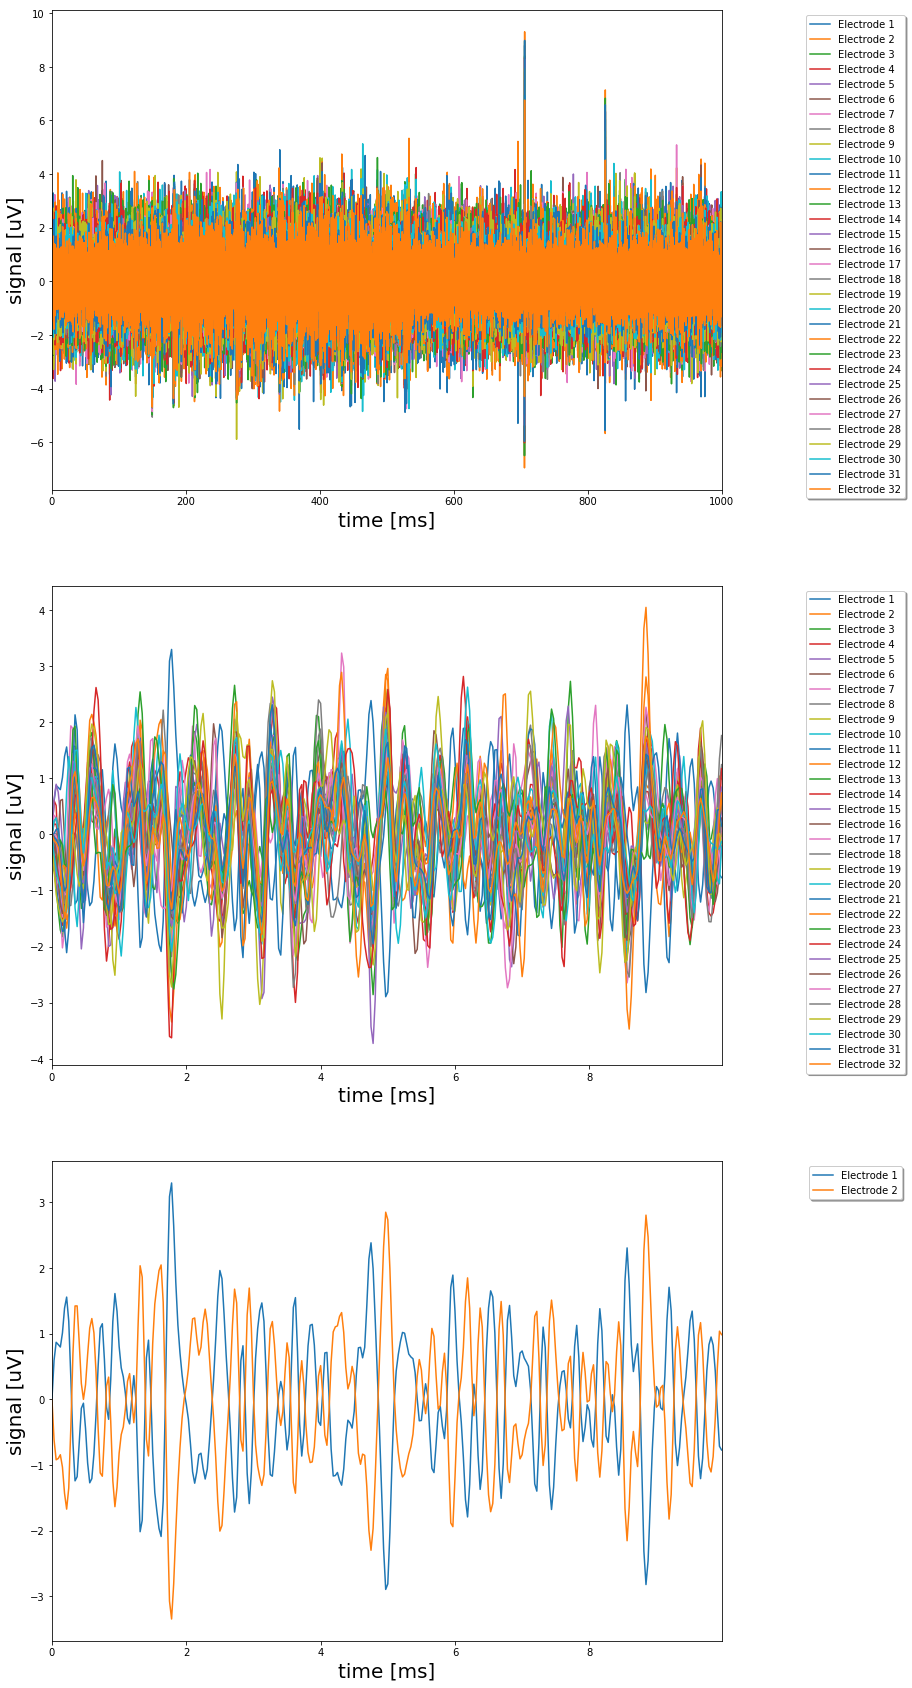

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

ax = axes[0]
ax = nrtk.vis.plot_signal_electrodes(ax, signals)

ax = axes[1]
ax = nrtk.vis.plot_signal_electrodes(ax, signals, t_min=0., t_max=0.01)

ax = axes[2]
ax = nrtk.vis.plot_signal_electrodes(ax, signals, t_min=0., t_max=0.01, electrodes_ids=[0, 1])

## Waterfall view

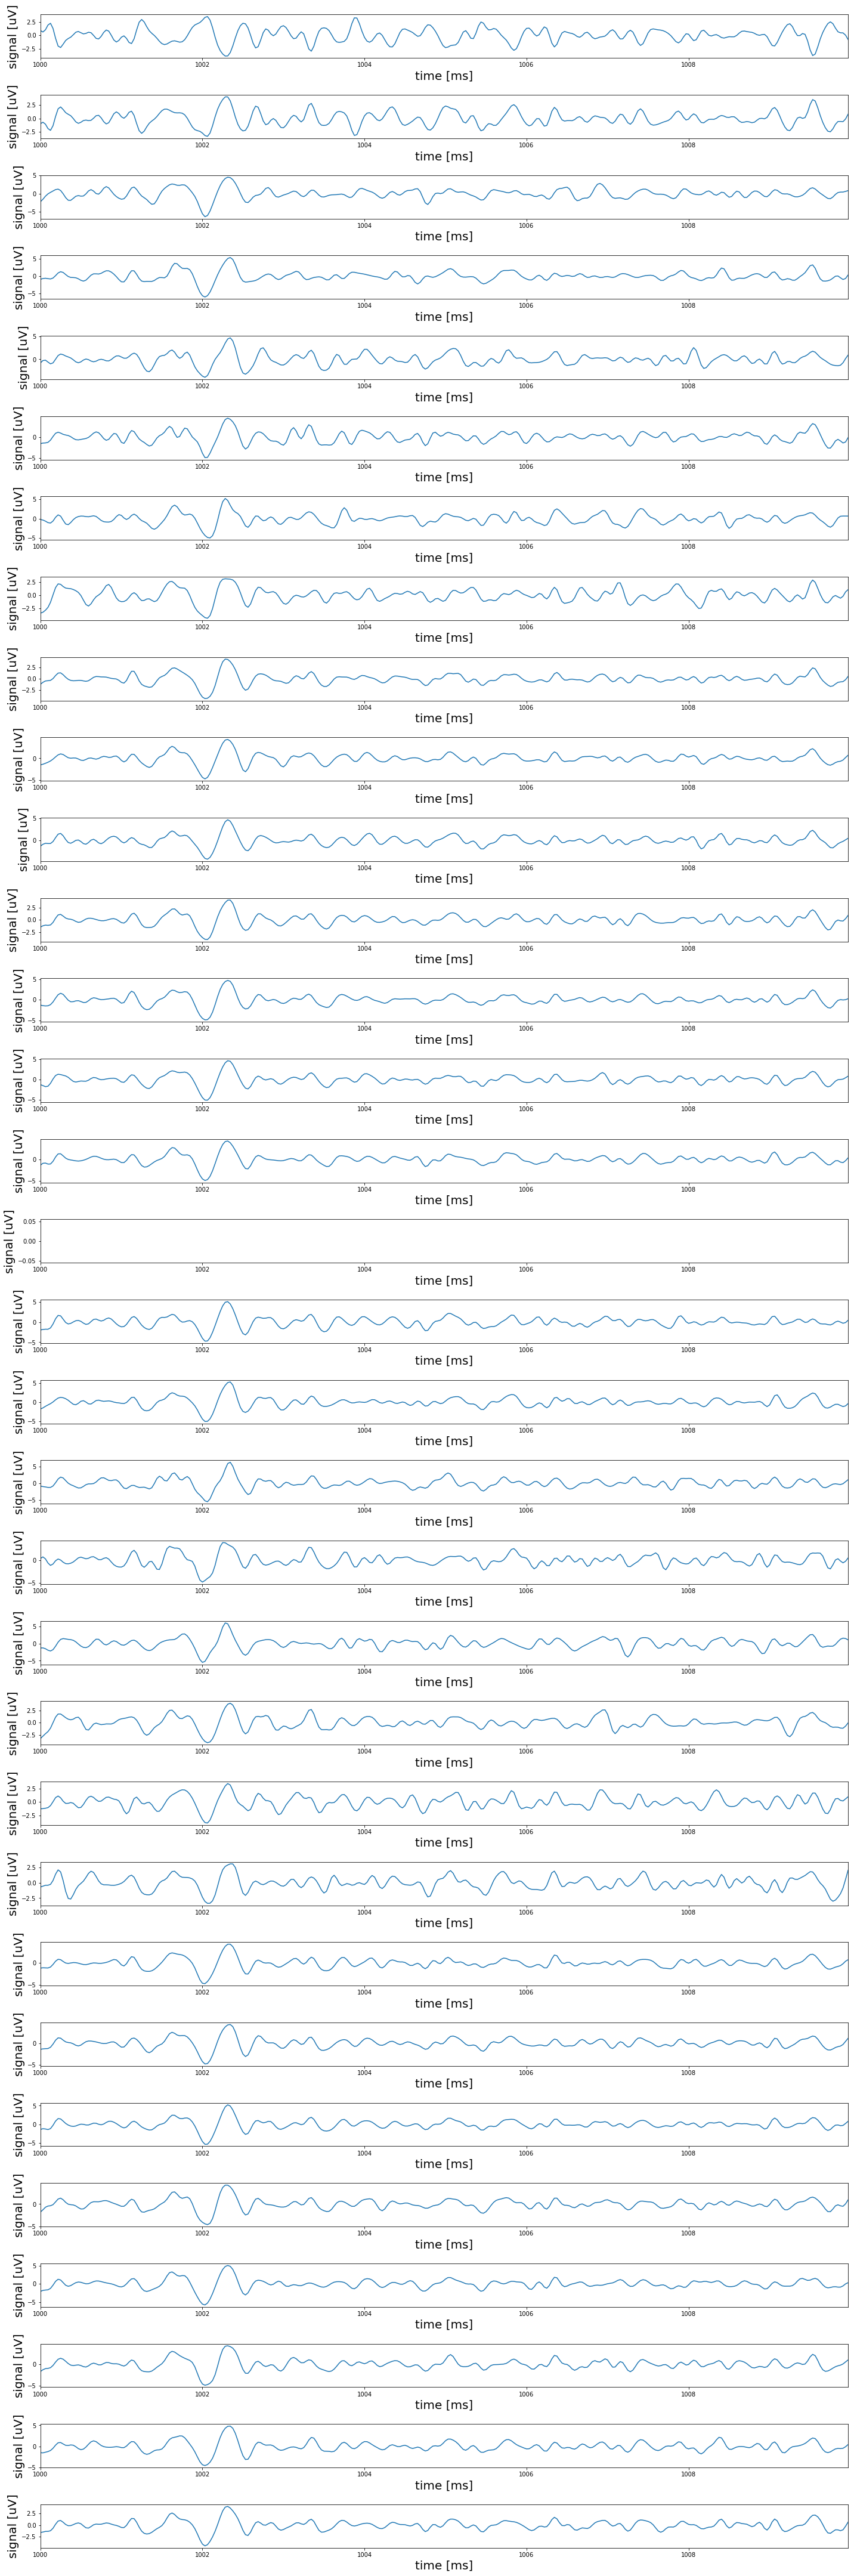

In [28]:
n_electrodes, _ = signals.shape

fig, axes = plt.subplots(nrows=n_electrodes, ncols=1, figsize=(20, 60))
for i in range(n_electrodes):
    ax = axes[i]
    nrtk.vis.plot_signal(ax, signals[i], label='Electrode %d' % (i+1), t_min=1., t_max=1.01)
plt.tight_layout()

## Correlations

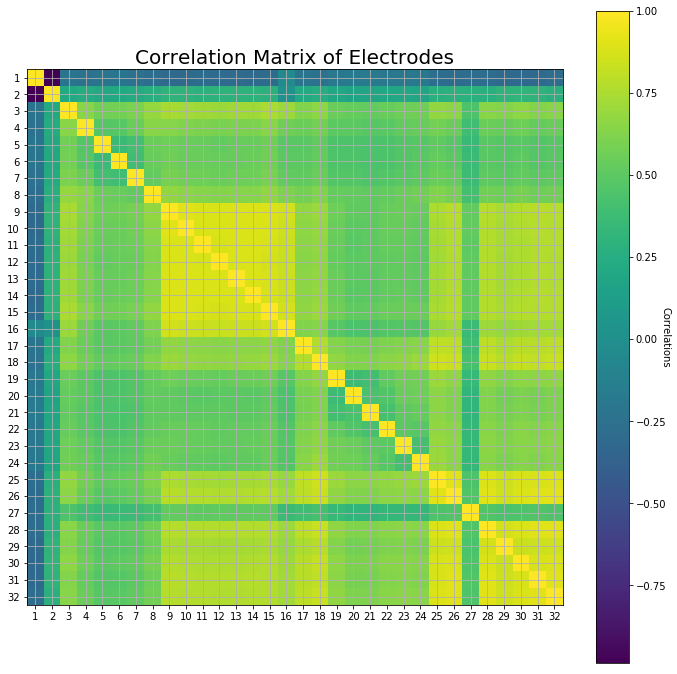

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = nrtk.vis.plot_correlation(fig, ax, signals)

# Extract Spikes

In [11]:
peaks_path = os.path.join(OUTPUT_DIR, 'extract_spikes.npy')
peaks = np.load(peaks_path).item()

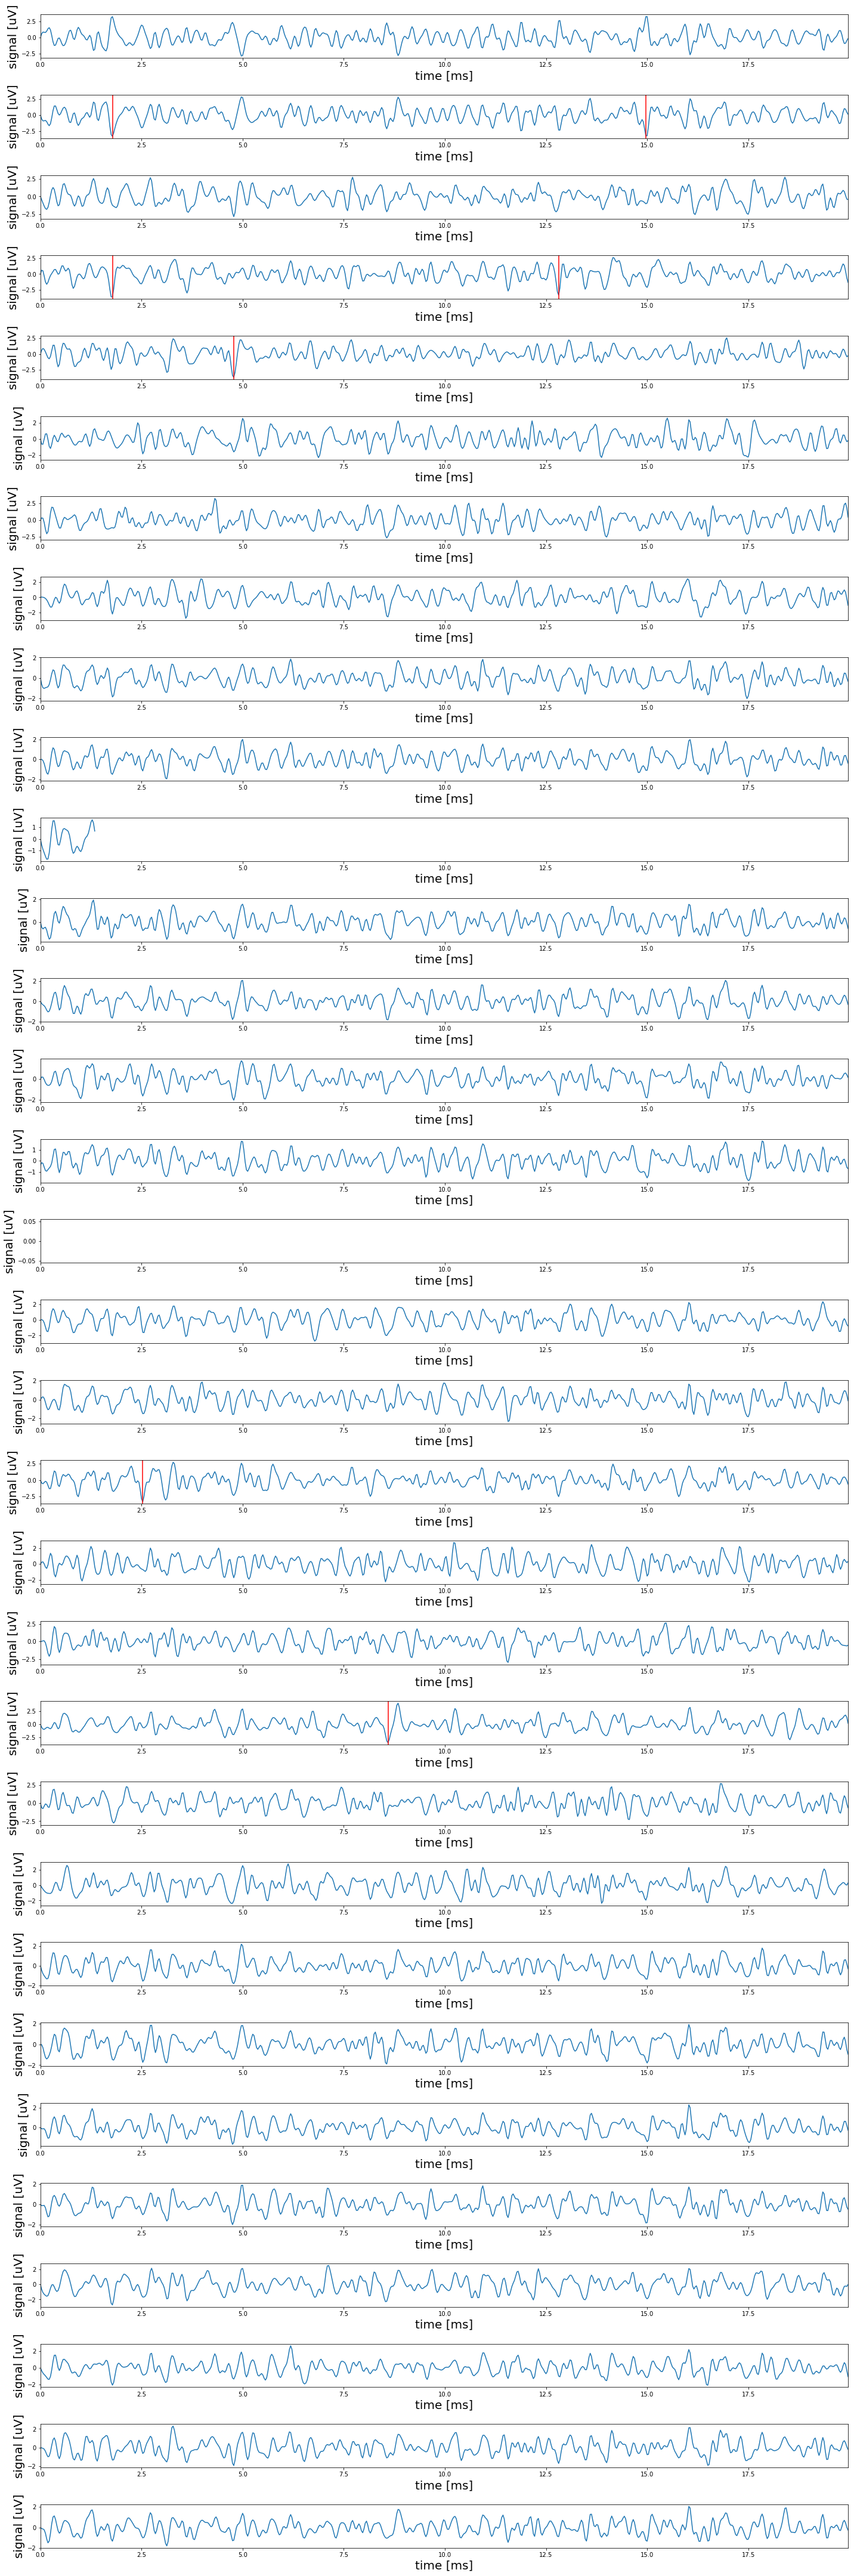

In [14]:
n_electrodes, _ = signals.shape
time = nrtk.vis.get_time(signals)

fig, axes = plt.subplots(nrows=n_electrodes, ncols=1, figsize=(20, 60))
for i in range(n_electrodes):
    ax = axes[i]
    nrtk.vis.plot_signal(ax, signals[i], label='Electrode %d' % (i+1), t_min=0., t_max=0.02)
    peak_0_msecs = 1000 * time[peaks[i]['ids'][0]]
    peak_1_msecs = 1000 * time[peaks[i]['ids'][1]]
    ax.axvline(x=peak_0_msecs, color='red')
    ax.axvline(x=peak_1_msecs, color='red')
plt.tight_layout()

## Cluster peaks: spike sorting

In [215]:
cmap = plt.cm.get_cmap('viridis', N_CLUSTERS)    # Discrete color map
cmaplist = [cmap(i) for i in range(cmap.N)]

def pca_cluster_peaks(filt_samples, peaks, 
                      n_components=N_PCA_COMPONENTS, n_clusters=N_CLUSTERS, 
                      clip=PEAK_WINDOW_CLIP, normalization=False):
    pca_clustering = {}

    n_electrodes, n_samples = filt_samples.shape  
    for electrode_id in range(n_electrodes):
        # TODO(nina): Remove this DEBUG
        if electrode_id > 0:
            break 
    
        peaks_electrode = peaks[electrode_id]
        n_peaks = len(peaks_electrode['ids'])

        signals = []
        peak_ids = []  # peak ids that are conserved
        
        for peak_id in peaks_electrode['ids']:
            start_idx = np.int(peak_id - clip / 2)
            end_idx = np.int(peak_id + clip / 2)

            if (start_idx > 1 and end_idx < n_samples):
                signal = filt_samples[electrode_id, start_idx:end_idx]
                if np.sum(np.isnan(signal)) == 0:
                    signals.append(signal)
                    peak_ids.append(peak_id)

        data = np.array(signals)
        assert data.shape[1] == clip
        
        if normalization:
            scaler = sklearn.preprocessing.MinMaxScaler()
            data = scaler.fit_transform(data)
        
        pca = PCA(n_components=n_components)
        projected_data = pca.fit_transform(data)
        
        kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, random_state=1990)
        kmeans_res = kmeans.fit(projected_data)
        
        pca_clustering[electrode_id] = {}
        pca_clustering[electrode_id]['peaks_ids'] = peak_ids
        pca_clustering[electrode_id]['data'] = data
        pca_clustering[electrode_id]['projected_data'] = projected_data
        pca_clustering[electrode_id]['ratio_variance_explained'] = pca.explained_variance_ratio_
        pca_clustering[electrode_id]['assignments'] = kmeans_res.labels_
        pca_clustering[electrode_id]['centers'] = kmeans_res.cluster_centers_        

    return pca_clustering


In [216]:
pca_clustering = pca_cluster_peaks(samples_no_flat, peaks)

There are 19219 peaks assigned to cluster 0
There are 566 peaks assigned to cluster 1
There are 3896 peaks assigned to cluster 2


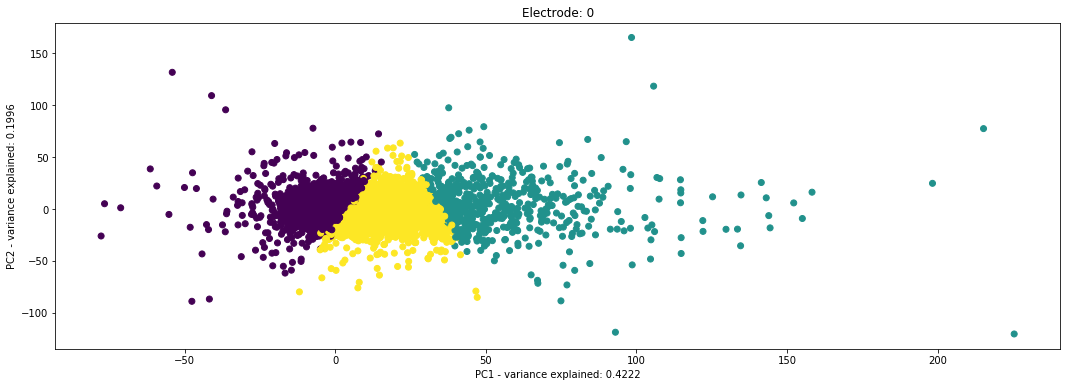

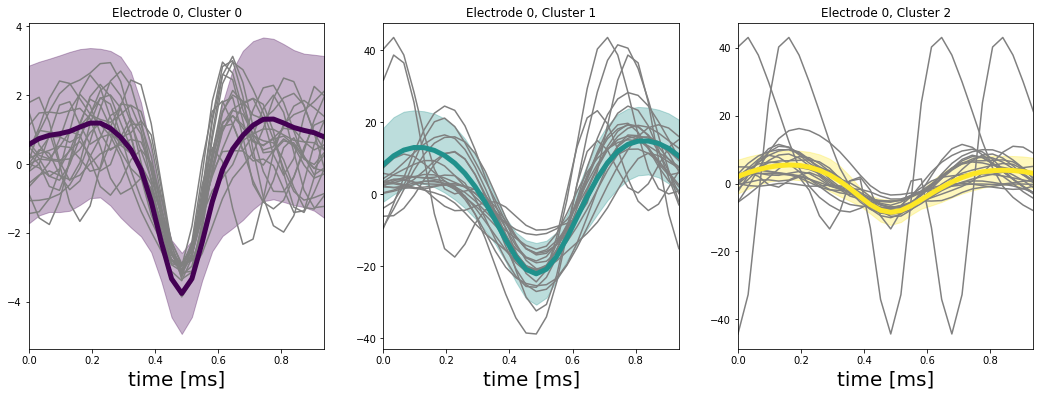

In [217]:
fig, ax = plt.subplots(figsize=(18, 6))

ax = plot_clustering(ax, pca_clustering)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i in range(N_CLUSTERS):
    ax = axes[i]
    ax = plot_centers(ax, pca_clustering, center_id=i)

# 2. Load and Plot NVT files: Video Tracking

In [53]:
def load_nvt(data_file, remove_empty=False):
    """
    Read Neuralynx NVT data.
    https://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    """
    # QUESTION: Why is there less time steps than raw data? len(nvt_raw['TimeStamp']) != len(nvt_raw['extracted_x']) 
    with open(data_file, 'rb') as fid:
        fid.seek(HEADER_SIZE)
        
        data_format = np.dtype([
            ('stx', np.uint16),
            ('id', np.uint16),
            ('data_size', np.uint16),
            ('TimeStamp', np.uint64), # in um
            ('Points', np.uint32, 400),
            ('nrc', np.int16),  # Unused
            ('extracted_x', np.int32),
            ('extracted_y', np.int32),
            ('extracted_angle', np.int32),
            ('targets', np.int32, 50)])
        raw = np.fromfile(fid, dtype=data_format)
    
    selected_raw = dict()
    selected_raw['TimeStamp'] = raw['TimeStamp']
    selected_raw['extracted_x'] = np.array(raw['extracted_x'], dtype=float)
    selected_raw['extracted_y'] = np.array(raw['extracted_y'], dtype=float)
    selected_raw['targets'] = np.array(raw['targets'], dtype=float)
        
    if remove_empty:
        empty_idx = (raw['extracted_x'] == 0) & (raw['extracted_y'] == 0)
        for key in selected_raw:
            selected_raw[key] = selected_raw[key][~empty_idx]

    return nvt_raw

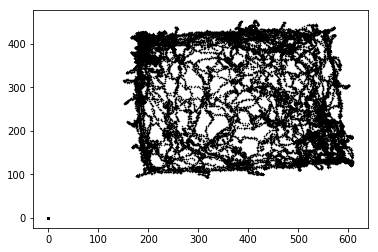

In [54]:
# QUESTION: Why doesn't it look like a labyrinth?
plt.plot(nvt_raw['extracted_x'], nvt_raw['extracted_y'], 'k.', ms=1)
plt.show()

In [55]:
# TODO(nina): These are placeholders, replace them with real values
pxl_to_cm_x = 1
pxl_to_cm_y = 1
x_cm = nvt_raw['extracted_x'] / pxl_to_cm_x
y_cm = nvt_raw['extracted_y'] / pxl_to_cm_y
xy = np.hstack([x_cm, y_cm])
time = nvt_raw['TimeStamp']

In [237]:
#electrode_id = 0
#filename = 'CSC{}.ncs'.format(electrode_id+1)
#filepath = os.path.join(data_dir, filename)
#print('Loading %s...' % filepath)
#raw_ncs = load_ncs(filepath)

nvt_file = os.path.join(DATA_DIR, 'VT1.nvt')
print(nvt_file)
nvt_raw = nrtk.io.load_nvt(nvt_file)
print(nvt_raw)

timestamps_ncs = raw_ncs['TimeStamp']
timestamps_nvt = raw_nvt['TimeStamp']
intersection = np.intersect1d(timestamps_ncs, time_stamps_nvt)

/neuro/recordings/2018-05-31_15-43-39/VT1.nvt
{'TimeStamp': array([104904529770, 104904545706, 104904561643, ..., 105717859262,
       105717875710, 105717891950], dtype=uint64), 'extracted_x': array([362., 362., 362., ..., 435., 432., 432.]), 'extracted_y': array([398., 399., 398., ..., 348., 346., 344.]), 'targets': array([[1.09995659e+09, 5.62823530e+08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10002212e+09, 5.62889066e+08, 2.60509210e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.09995659e+09, 5.62823530e+08, 2.62475250e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.09648325e+09, 2.29052670e+07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.09628664e+09, 2.25775850e+07, 5.59677870e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.09635218e+09, 2.26431230e+07, 5.59350189e+08, ...,
        0.0000000

NameError: name 'raw_ncs' is not defined

In [ ]:
# TODO(nina): Spike sorting = isolate neurons by clustering.
# --> Needed to isolate place neurones and hope to decode position